In [12]:
import qutip as qtp

## with ZZ coupling

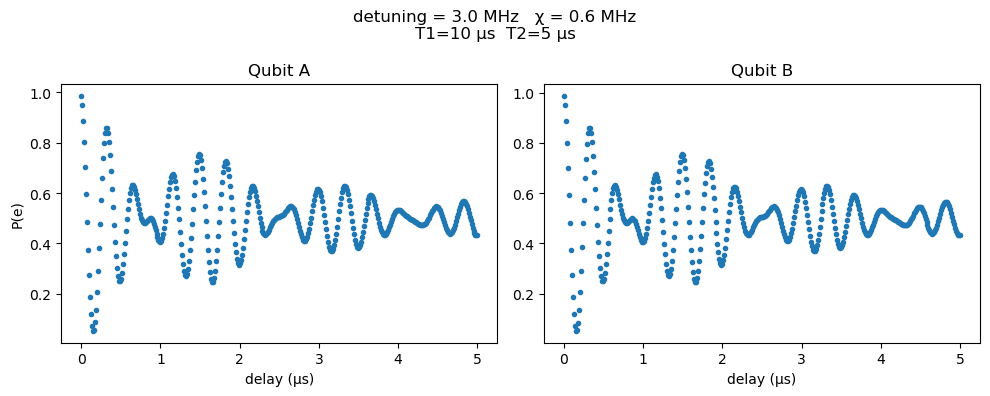

In [115]:

# Two-qubit simultaneous-Ramsey with ZZ coupling + T1/T2
# ---------------------------------------------------------------
import numpy as np, qutip as qt, matplotlib.pyplot as plt

fA, fB   = 3.000e9, 3.040e9          # qubit bare freqs  (Hz)
detA = detB = 3e6                  # Ramsey detuning   (Hz)
chi_MHz     = 0.6                   # ZZ  (MHz)  (0 → no beating)

T1_A = T1_B = 10e-6                 # T1  (s)
T2_A = T2_B = 5e-6                 # desired T2 (s)

t_ns = np.linspace(0, 5000, 401)    # free-evolution delays (ns)


wA,wB   = 2*np.pi*np.array([fA,fB])
chi     = 2*np.pi*chi_MHz*1e6
EdA,EdB = 0.01*wA, 0.01*wB          # Rabi → τπ/2≈8 ns
pi2A,pi2B = np.pi/(2*EdA), np.pi/(2*EdB)
tau_p   = float(max(pi2A,pi2B))

I,sx,sz,sm = qt.qeye(2),qt.sigmax(),qt.sigmaz(),qt.destroy(2)
sxA,sxB = qt.tensor(sx,I), qt.tensor(I,sx)
szA,szB = qt.tensor(sz,I), qt.tensor(I,sz)
smA,smB = qt.tensor(sm,I), qt.tensor(I,sm)
nA,nB   = qt.tensor(qt.num(2),I),   qt.tensor(I,qt.num(2))

# ─── Collapse operators for given T1 and T2 ─────────────────
def collapse_ops(T1,T2,sm_op,sz_op):
    g1  = 1/T1
    gphi = max(0, 1/T2 - g1/2)      # 1/T2 = 1/(2T1)+1/Tphi
    return [np.sqrt(g1)*sm_op, np.sqrt(gphi)*sz_op]

c_ops = ( collapse_ops(T1_A,T2_A,smA,szA) +
          collapse_ops(T1_B,T2_B,smB,szB) )

# ─── Static Hamiltonian ───────────────────────────
H0 = 0.5*wA*szA + 0.5*wB*szB + chi/4*szA*szB
def gate_coeff(ω,amp,t0,t1):
    return lambda t,args=None: amp*np.cos(ω*t) if t0<=t<t1 else 0.0

def H_sequence(delay_s):
    t1s,t1e = 0.0,        pi2A
    t2s,t2e = tau_p,      tau_p+pi2A
    return [H0,
            [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t1s, t1e)],
            [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t1s, pi2B)],
            [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t2s+delay_s, t2e+delay_s)],
            [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t2s+delay_s, pi2B+tau_p+delay_s)]], \
           2*tau_p + delay_s

# ───  Ramsey point (single integration) ──────────────────────
opts = qt.Options(nsteps=20000, store_final_state=True, atol=1e-7, rtol=1e-6)
psi_g = qt.tensor(qt.basis(2,0), qt.basis(2,0))

def ramsey(delay_ns):
    τ = delay_ns*1e-9
    H,t_tot = H_sequence(τ)
    tlist = np.linspace(0,t_tot,int(t_tot/2e-9)+1)  # 2-ns solver step
    st = qt.mesolve(H, psi_g, tlist, c_ops, [], options=opts).states[-1]
    return qt.expect(nA,st), qt.expect(nB,st)

expA,expB = np.array([ramsey(t) for t in t_ns]).T

# ───  Plot ───────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.subplot(121); plt.plot(t_ns/1000,expA,'.'); plt.title('Qubit A'); plt.xlabel('delay (µs)'); plt.ylabel('P(e)')
plt.subplot(122); plt.plot(t_ns/1000,expB,'.'); plt.title('Qubit B'); plt.xlabel('delay (µs)')
plt.suptitle(f'detuning = {detA/1e6:.1f} MHz   χ = {chi_MHz:.1f} MHz\nT1={T1_A*1e6:.0f} µs  T2={T2_A*1e6:.0f} µs')
plt.tight_layout(); plt.show()


## FIT with one amplitude
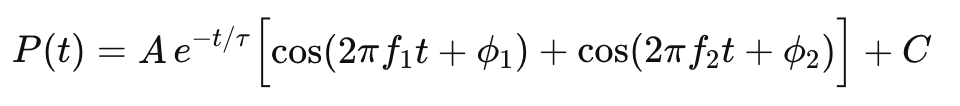

Qubit-A:  f1 = 3.301 MHz   f2 = 2.700 MHz   T2 = 2.5 µs
Qubit-B:  f1 = 3.301 MHz   f2 = 2.700 MHz   T2 = 2.5 µs


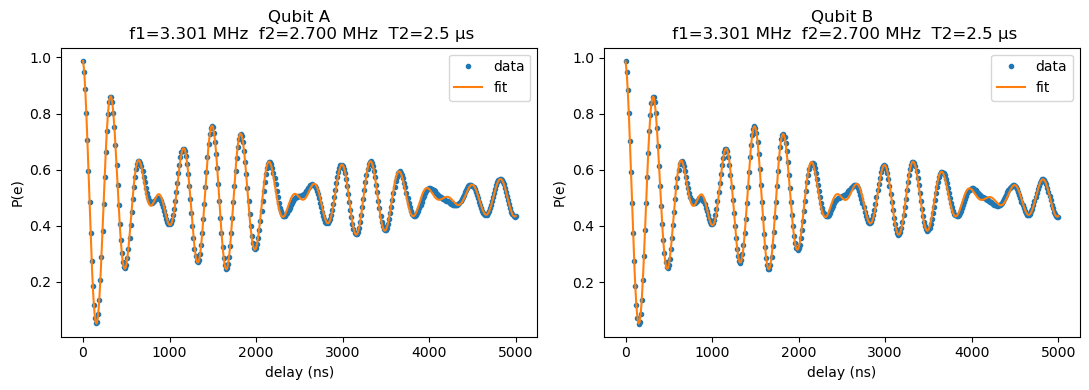

In [121]:
# ==================================================================
# Fit Ramsey beating to two decaying cosines  (requires SciPy ≥1.6)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# --- model --------------------------------------------------------
def double_cos(t_s, A, f1, f2, phi1, phi2, T2, C):
    env = A * np.exp(-t_s / T2)
    return env * (np.cos(2*np.pi*f1*t_s + phi1) +
                  np.cos(2*np.pi*f2*t_s + phi2)) + C

# --- helper: crude initial guesses from FFT ----------------------
def guess_params(t_ns, y):
    t_s = t_ns*1e-9
    C0  = y.mean()
    A0  = 0.5*(y.max()-y.min())
    fs  = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec= np.abs(rfft(y-C0))
    peak_idx = spec.argsort()[-2:][::-1]   # two largest peaks
    f1, f2 = fs[peak_idx]
    return [A0, f1, f2, 0, 0, 5e-6, C0]

# --- fit both qubits ---------------------------------------------
p0A = guess_params(t_ns, expA)
p0B = guess_params(t_ns, expB)
t_s = t_ns*1e-9

bounds = ([0,0,0,-np.pi,-np.pi,0,0],
          [1,20e6,20e6,np.pi,np.pi,1e-3,1])

pA,_ = curve_fit(double_cos, t_s, expA, p0=p0A, bounds=bounds, maxfev=30000)
pB,_ = curve_fit(double_cos, t_s, expB, p0=p0B, bounds=bounds, maxfev=30000)

# --- report -------------------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[1]/1e6:.3f} MHz   f2 = {p[2]/1e6:.3f} MHz   "
          f"T2 = {p[5]*1e6:.1f} µs")

report("Qubit-A", pA)
report("Qubit-B", pB)

# --- plots ------------------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1200)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k,(y,p,title) in enumerate(zip((expA,expB),(pA,pB),("Qubit A","Qubit B"))):
    ax[k].plot(t_ns, y, '.', label='data')
    ax[k].plot(tf_ns,
               double_cos(tf_ns*1e-9, *p), label='fit')
    ax[k].set_title(title+
        f"\n f1={p[1]/1e6:.3f} MHz  f2={p[2]/1e6:.3f} MHz  T2={p[5]*1e6:.1f} µs")
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()


## fit with two amplitudes 
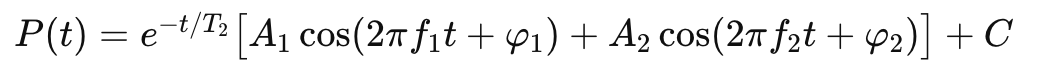

Qubit-A:  f1 = 3.299 MHz   f2 = 2.699 MHz   A1 = 0.23  A2 = 0.27   T2 = 2.5 µs
Qubit-B:  f1 = 3.299 MHz   f2 = 2.698 MHz   A1 = 0.23  A2 = 0.27   T2 = 2.5 µs


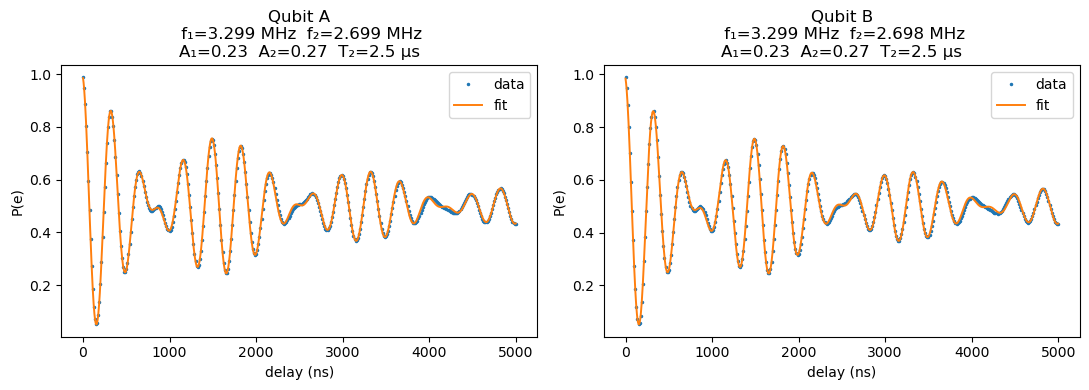

In [116]:
# ==================================================================
# Fit Ramsey beating with *independent* amplitudes for each branch
# Assumes t_ns, expA, expB are defined (from the simulation cell)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# ---------- model -------------------------------------------------
def two_amp_cos(t_s, A1, A2, f1, f2, phi1, phi2, T2, C):
    env = np.exp(-t_s / T2)
    return env * (A1*np.cos(2*np.pi*f1*t_s + phi1) +
                  A2*np.cos(2*np.pi*f2*t_s + phi2)) + C

# ---------- initial-guess helper (FFT) ---------------------------
def guess_params(t_ns, y):
    t_s = t_ns * 1e-9
    C0  = y.mean()
    
    y0  = y - C0
    A_guess = 0.5*(y.max()-y.min())
    fs   = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec = np.abs(rfft(y0))
    idx  = spec.argsort()[-2:][::-1]          # two largest peaks
    f1, f2 = fs[idx]
    return [A_guess, A_guess, f1, f2, 0.0, 0.0, 5e-6, C0]

# ---------- fit both qubits --------------------------------------
t_s = t_ns * 1e-9
p0A = guess_params(t_ns, expA)
p0B = guess_params(t_ns, expB)

bounds = ([0,0,      0,      0, -np.pi, -np.pi,        0, 0],   # lower
          [1,1,  20e6,  20e6,  np.pi,  np.pi,   1e-3, 1])       # upper

pA, _ = curve_fit(two_amp_cos, t_s, expA, p0=p0A,
                  bounds=bounds, maxfev=50000)
pB, _ = curve_fit(two_amp_cos, t_s, expB, p0=p0B,
                  bounds=bounds, maxfev=50000)

# ---------- report ----------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[2]/1e6:.3f} MHz   "
          f"f2 = {p[3]/1e6:.3f} MHz   "
          f"A1 = {p[0]:.2f}  A2 = {p[1]:.2f}   "
          f"T2 = {p[6]*1e6:.1f} µs")

report("Qubit-A", pA)
report("Qubit-B", pB)

# ---------- plots ---------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1600)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k, (y, p, title) in enumerate(zip((expA, expB),
                                      (pA, pB),
                                      ("Qubit A", "Qubit B"))):
    ax[k].plot(t_ns, y, '.', ms=3, label='data')
    ax[k].plot(tf_ns,
               two_amp_cos(tf_ns*1e-9, *p), lw=1.4, label='fit')
    ax[k].set_title(title +
      (f"\n f₁={p[2]/1e6:.3f} MHz  f₂={p[3]/1e6:.3f} MHz\n"
       f"A₁={p[0]:.2f}  A₂={p[1]:.2f}  T₂={p[6]*1e6:.1f} µs"))
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()
